# Tutorial: Differentiable Information Imbalance (JAX implementation)

The Differentiable Information Imbalance (DII) is a tool to automatically learn the optimal distance function A to predict close pair of points in a target distance space B. 

This notebook shows a brief tutorial of the JAX implementation of the DII, available in the 'DiffImbalance' class. For more information, please refer to the diff_imbalance module in the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html

In [24]:
from dadapy import DiffImbalance
import matplotlib.pyplot as plt
import numpy as np
import os
import jax

jax.config.update('jax_platform_name', 'cpu') # can run on 'cpu' or 'gpu'; restart the
                                              # notebook kernel to make this change effective
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false' # avoid jax memory preallocation

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Optimization on a 5D anisotropic Gaussian dataset

The differentiable Information Imbalance is computed here as
\begin{equation}
DII(d^A(\boldsymbol{w})\rightarrow B) = \frac{2}{N^2} \sum_{i,j=1}^N\, c_{ij}^A\, r_{ij}^B\, \hspace{1cm} \Bigg( c_{ij}^A = \frac{\exp(-d_{ij}^A(\boldsymbol{w})^2/\lambda)}{\sum_{k(\neq i)}{\exp(-d_{ik}^A(\boldsymbol{w})^2/\lambda)}}\Bigg).
\end{equation}
Qualitatively, parameter $\lambda$ decides how many neighbors are considered - for very small $\lambda$, only the neigherest neighbor receives a weight of $~1$, and all other neighbors receive weights close to $0$.

In this example we show how to assign the optimal weights $\boldsymbol{w} = \{w_\alpha\}$ to the features $\{X_\alpha\}$ $(\alpha=1,...,D)$, which define space A, in order to optimize the prediction of distances in a target space B. We will construct space A using a 5-dimensional isotropic Gaussian distribution, and space B by reweighting its coordinates, resulting in a 5-dimensional anisotropic Gaussian.

The weights appear in the distance function as
\begin{equation}
d_{ij}^A(\boldsymbol{w}) = \Bigg[\sum_{\alpha=1}^D\,(w_{\alpha}X_\alpha^i - w_{\alpha}X_\alpha^j)^2 \Bigg]^{1/2},
\end{equation}
and they are optimized by gradient descent.

In [26]:
# generate test data
weights_ground_truth = np.array([10, 3, 1, 30, 7.3])
np.random.seed(0)
data_A = np.random.normal(loc=0, scale=1.0, size=(500,5)) # sample 500 points
data_B = weights_ground_truth[np.newaxis,:] * data_A

# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A=data_A, # matrix of shape (N,D_A)
    data_B=data_B, # matrix of shape (N,D_B)
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=500,
    batches_per_epoch=1, # no mini-batches
    l1_strength=0.0, # no l1 regularization
    point_adapt_lambda=True,
    k_init=1,
    k_final=1,
    params_init=None, # automatically set to [0.1,0.1,0.1,0.1,0.1]
    optimizer_name="sgd", # possible choices: "sgd", "adam", "adamw"
    learning_rate=1e-2,
    learning_rate_decay=None, # possible choices: None, "cos", "exp"
    num_points_rows=None,
)
weights, imbs = dii.train()

print(f"Ground truth weights = {weights_ground_truth}\n")
# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}")

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Ground truth weights = [10.   3.   1.  30.   7.3]

Learnt weights: [ 9.99  2.95  0.89 30.    7.31]


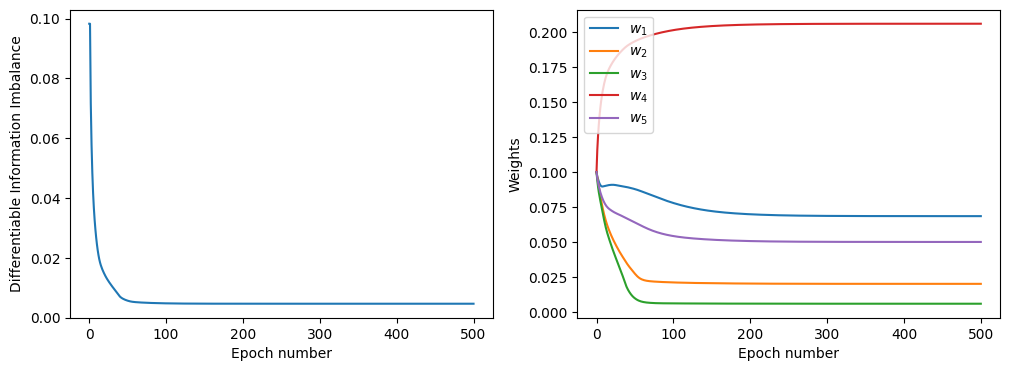

In [27]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:,0], label="$w_1$")
ax2.plot(weights[:,1], label="$w_2$")
ax2.plot(weights[:,2], label="$w_3$")
ax2.plot(weights[:,3], label="$w_4$")
ax2.plot(weights[:,4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()

The plots above show the convergence of the DII (left panel) and of the feature weights (right panel) as a function of the epoch number.

In this simple example we employed no decay schedule for the learning rate (argument 'learning_rate_decay'), although possible options are 'cos' (cosine decay) and 'exp' (learning rate is halved every 10 epochs). Although these schedules avoid "overshooting" the minimum and can improve the optimization of the DII, we suggest to always perform a first optimization in absence of any learning rate decay schedule, to verify that the number of epoches (argument 'num_epochs') is appropriate to ensure convergence.

In particularly noisy data sets, strategies to speed up and improve the DII optimization include the use of mini-batches (argument 'batches_per_epoch') coupled with more sophisticated optimizers (e.g. 'adam'), and the use of a larger neighborhood size for setting the parameter $\lambda$ adaptively (arguments 'k_init' and 'k_final').
Viable options are setting 'batches_per_epoch' such that each mini-batch contains ~100 points, and setting 'k_init' and 'k_final' such that ~5% of the points are included in each neighborhood. For example, if the original data set contains $N=500$ points, setting 'batches_per_epoch' to 5 results in mini-batches of $N'=100$ points each, and setting 'k_init' and 'k_final' to 5 allows selecting 5% of the points in each mini-batch:

In [28]:
# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A=data_A, # matrix of shape (N,D_A)
    data_B=data_B, # matrix of shape (N,D_B)
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=500,
    batches_per_epoch=5, # no mini-batches
    l1_strength=0.0, # no l1 regularization
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    params_init=None, # automatically set to [0.1,0.1,0.1,0.1,0.1]
    optimizer_name="adam", # possible choices: "sgd", "adam", "adamw"
    learning_rate=1e-2,
    learning_rate_decay="cos", # possible choices: None, "cos", "exp"
    num_points_rows=None,
)
weights, imbs = dii.train() # the outputs can also be accessed after training
                            # with dii.params_training and dii.imbs_training

print(f"Ground truth weights = {weights_ground_truth}\n")

# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}")

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Ground truth weights = [10.   3.   1.  30.   7.3]

Learnt weights: [10.04  2.86  0.57 30.    7.3 ]


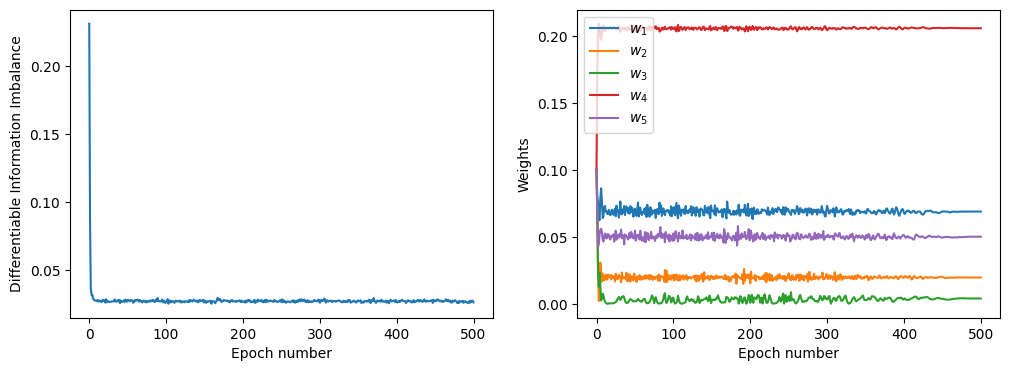

In [29]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:,0], label="$w_1$")
ax2.plot(weights[:,1], label="$w_2$")
ax2.plot(weights[:,2], label="$w_3$")
ax2.plot(weights[:,3], label="$w_4$")
ax2.plot(weights[:,4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()

In this case, the panel on the left depicts the DII computed, at each training epoch, over the last mini-batch employed in that epoch.
The DII can be computed on the full data set after convergence using the method 'return_final_dii'. For details on its arguments refer to the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html.

In [30]:
imb_final, _ = (
    dii.return_final_dii(
        compute_error=False,
        ratio_rows_columns=None, 
        seed=0, 
        discard_close_ind=0
    )
)
print(f"Optimal DII over full data set: {imb_final:2f}") # can also be accessed 
                                                         # through dii.imb_final

Optimal DII over full data set: 0.011225
